In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

In [2]:
# Reading the file with metrices
df_parking = gpd.read_file("F:/Berlin-DOP_2020/Processed images_new/parking_dist.gpkg", driver="GPKG", layer="parking_disolved_withdata", crs='EPSG:25833')

In [3]:
# Renaming the column heading
df_parking = df_parking.rename(columns={'True or False': 'True_or_False'})

In [4]:
# Adding the center point
df_parking.geometry = df_parking.representative_point()

C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\base.py:95: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = getattr(a_this, op)(*args, **kwargs).data
C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)


In [5]:
# Checking if the tru positives and false positives are marked properly
df_parking.True_or_False.unique()

array(['false', 'true'], dtype=object)

In [6]:
df_parking

index_right  id_x              label  parking_area_m2  \
0              0    98  PK-space-occupied        30.161748   
1              1    99  PK-space-occupied        27.762756   
2              2   101  PK-space-occupied        45.705855   
3              3   100  PK-space-occupied        45.705855   
4              4   102  PK-space-occupied        92.096478   
..           ...   ...                ...              ...   
962          962  3862  PK-space-occupied       110.107274   
963          963  3860  PK-space-occupied        55.962169   
964          964  3861  PK-space-occupied        55.962169   
965          965  3863  PK-space-occupied        20.812745   
966          966  3864  PK-space-occupied       109.203396   

     nearest_geometry_dis  id_y  parking_area_nearest_m2 True_or_False  \
0               26.571713   100                  15.4000         false   
1                9.544300   100                  15.4000         false   
2                1.451844   100                  15.4000         false   
3                1.451844   101                  22.8600         false   
4               11.022388   103                  33.2475          true   
..                    ...   ...                      ...           ...   
962              2.776756  3858                  69.0100          true   
963              1.810653  3861                   9.6100         false   
964              1.810653  3860                  27.6050          true   
965              7.632571  3859                   8.2450         false   
966             10.927497  3543                   6.0275          true   

                           geometry  
0    POINT (391036.832 5824011.911)  
1    POINT (391034.492 5824046.641)  
2    POINT (391029.664 5824038.159)  
3    POINT (391029.664 5824038.159)  
4    POINT (391022.494 5824052.635)  
..                              ...  
962  POINT (391958.039 5824862.370)  
963  POINT (391973.055 5824866.438)  
964  POINT (391973.055 5824866.438)  
965  POINT (391953.850 5824874.971)  
966  POINT (391956.236 5824961.115)  

[967 rows x 9 columns]

In [7]:
# K means clustering
n_init = 100
n_clusters = 3
clf = KMeans(init='k-means++', n_init=n_init, n_clusters=n_clusters,random_state=100, max_iter=1000)
labels = clf.fit_predict(df_parking[['parking_area_m2', 'nearest_geometry_dis']])

In [8]:
# Setting colours for True positives and false positives
colors = np.where(df_parking["True_or_False"]=='true','b','r')

blue_patch = mpatches.Patch(color='blue', label='True positives')
red_patch = mpatches.Patch(color='red', label='False Positives')


In [9]:
def colorbar_cartopy(mappable, cmap, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)   
    cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes, autoscale_on=True)
    obj = fig.colorbar(cmap, cax=cax, **kwargs)
    return obj

In [10]:
def draw_plots (n_clusters):
    n_init = 100
    clf = KMeans(init='k-means++', n_init=n_init, n_clusters=n_clusters,random_state=100, max_iter=1000) #Just creating the model
    labels = clf.fit_predict(df_parking[['parking_area_m2', 'nearest_geometry_dis']])
    # Adding the cluster number to the dataframe
    df_parking["cluster"] = labels
    
    # Calculating the percentage of true positives and flase positives captured by each clusture
    cluster_count=df_parking.groupby(['cluster', 'True_or_False']).count()
    cluster_count = cluster_count.iloc[:, 0:1]
    cluster_count['% of True_and_false'] = (100*cluster_count.index_right / cluster_count.groupby(level=0).index_right.transform(sum))
    cluster_count
    
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    img = ax.scatter(df_parking.parking_area_m2, df_parking.nearest_geometry_dis, c=labels, 
                 s=15, cmap=plt.cm.get_cmap('Set2', n_clusters))
    cb = colorbar_cartopy(ax, img)
    cb.set_label('Cluster Label')
    cb.ax.yaxis.set_ticks(range(n_clusters))
    ax.set_title('Cluster Label')
    ax.set_xlabel('Parking space area ($m^2$)')
    ax.set_ylabel('Distance to the next nearest parking (m)')

    ax2 = f.add_subplot(122)
    img2 = ax2.scatter(df_parking.parking_area_m2, df_parking.nearest_geometry_dis, c=colors, s=15, alpha = 0.5)
    ax2.set_title("True label")
    ax2.set_xlabel('Parking space area ($m^2$)')
    ax2.set_ylabel('Distance to the next nearest parking (m)')
    ax2.legend(handles=[blue_patch,red_patch])

    return plt.tight_layout(), cluster_count

(None,
                        index_right  % of True_and_false
 cluster True_or_False                                  
 0       false                   92            82.882883
         true                    19            17.117117
 1       false                   38            14.448669
         true                   225            85.551331
 2       true                    34           100.000000
 3       false                  103            28.219178
         true                   262            71.780822
 4       false                    1             1.818182
         true                    54            98.181818
 5       false                   18            12.949640
         true                   121            87.050360)

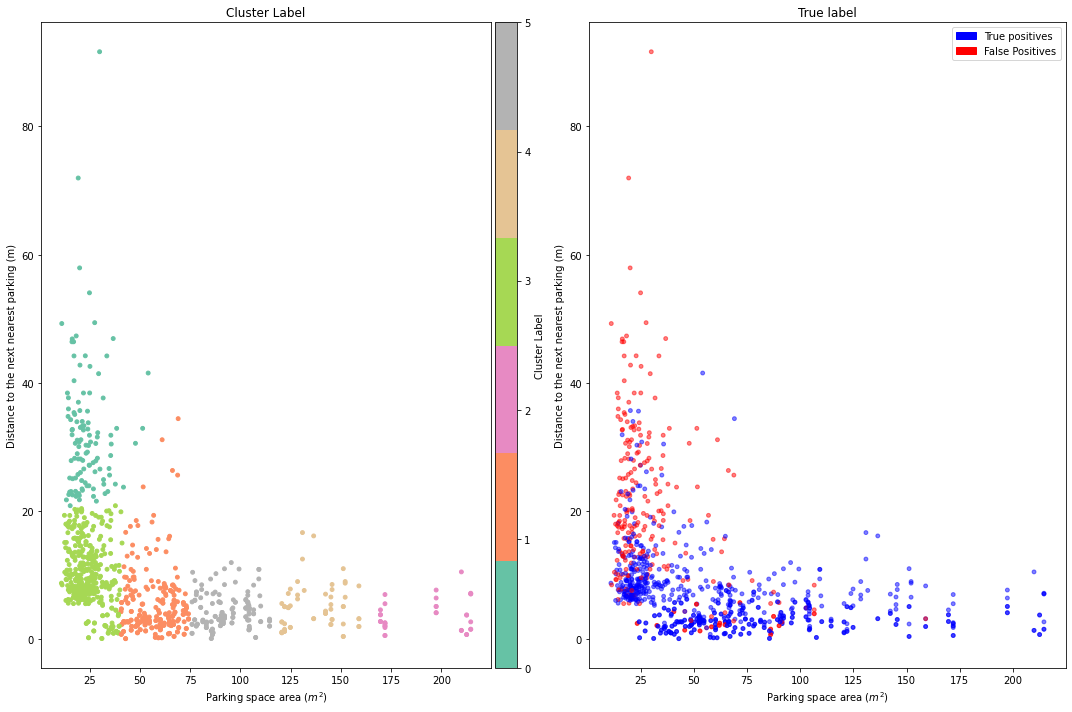

In [11]:
draw_plots(6)

Comparing with the population

In [12]:
df_pop = gpd.read_file("F:/Berlin-DOP_2020/Processed images_new/Pred_analysis.geojson")

C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\array.py:91: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [13]:
df_pop

fid  id_x              label  parking_area_m2  nearest_geometry_dis  \
0        1     1  PK-space-occupied          10.5250              9.398797   
1        2     2  PK-space-occupied          12.2575             26.399800   
2        3     4  PK-space-occupied          20.5600              1.126644   
3        4     3  PK-space-occupied          11.0450             10.902318   
4        5     5  PK-space-occupied          14.6600              1.126644   
...    ...   ...                ...              ...                   ...   
8971  8972  8980  PK-space-occupied           2.9750             21.742114   
8972  8973  8981  PK-space-occupied           7.9675              2.433225   
8973  8974  8982  PK-space-occupied          18.2300              3.853211   
8974  8975  8983  PK-space-occupied          12.6250             21.742114   
8975  8976  8984     PK-space-empty           8.6100              2.433225   

      id_y  parking_area_nearest_m2  \
0        5                  14.6600   
1        5                  14.6600   
2        5                  14.6600   
3        8                  14.5175   
4        4                  20.5600   
...    ...                      ...   
8971  8983                  12.6250   
8972  8984                   8.6100   
8973  8984                   8.6100   
8974  8980                   2.9750   
8975  8981                   7.9675   

                                               geometry  
0     MULTIPOLYGON (((391033.600 5824044.550, 391034...  
1     MULTIPOLYGON (((391038.600 5824010.850, 391039...  
2     MULTIPOLYGON (((391032.100 5824035.850, 391032...  
3     MULTIPOLYGON (((391018.550 5824050.000, 391018...  
4     MULTIPOLYGON (((391031.700 5824035.850, 391031...  
...                                                 ...  
8971  MULTIPOLYGON (((392978.800 5824894.250, 392979...  
8972  MULTIPOLYGON (((392994.200 5824927.750, 392994...  
8973  MULTIPOLYGON (((392993.700 5824932.450, 392994...  
8974  MULTIPOLYGON (((392958.900 5824907.950, 392959...  
8975  MULTIPOLYGON (((392992.300 5824930.050, 392992...  

[8976 rows x 8 columns]

In [20]:
df_pop.geometry = df_pop.geometry.buffer(1)
df_pop["parking_area_m2"] = df_pop['geometry'].area

# Adding the center point
df_pop.geometry = df_pop.representative_point()

C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\base.py:95: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = getattr(a_this, op)(*args, **kwargs).data
C:\Users\Bashi\.conda\envs\test\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)


In [21]:
# K means clustering for population
n_init_pop = 100
n_clusters_pop = 3
clf_pop = KMeans(init='k-means++', n_init=n_init_pop, n_clusters=n_clusters_pop,random_state=100, max_iter=1000)
labels_pop = clf_pop.fit_predict(df_pop[['parking_area_m2', 'nearest_geometry_dis']])

In [22]:
def draw_plots_2 (n_clusters):
    n_init = 100
    clf = KMeans(init='k-means++', n_init=n_init, n_clusters=n_clusters,random_state=100, max_iter=1000) #Just creating the model
    labels = clf.fit_predict(df_pop[['parking_area_m2', 'nearest_geometry_dis']])
    # Adding the cluster number to the dataframe
    df_pop["cluster"] = labels
    
    # Calculating the percentage of true positives and flase positives captured by each clusture
#     cluster_count=df_pop.groupby(['cluster', 'True_or_False']).count()
#     cluster_count = cluster_count.iloc[:, 0:1]
#     cluster_count['% of True_and_false'] = (100*cluster_count.fid / cluster_count.groupby(level=0).fid.transform(sum))
#     cluster_count
    
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(121)
    img = ax.scatter(df_pop.parking_area_m2, df_pop.nearest_geometry_dis, c=labels, 
                 s=15, cmap=plt.cm.get_cmap('Set2', n_clusters))
    cb = colorbar_cartopy(ax, img)
    cb.set_label('Cluster Label')
    cb.ax.yaxis.set_ticks(range(n_clusters))
    ax.set_title('Cluster Label')
    ax.set_xlabel('Parking space area ($m^2$)')
    ax.set_ylabel('Distance to the next nearest parking (m)')

#     ax2 = f.add_subplot(122)
#     img2 = ax2.scatter(df_parking.parking_area_m2, df_parking.nearest_geometry_dis, c=colors, s=15, alpha = 0.5)
#     ax2.set_title("True label")
#     ax2.set_xlabel('Parking space area ($m^2$)')
#     ax2.set_ylabel('Distance to the next nearest parking (m)')
#     ax2.legend(handles=[blue_patch,red_patch])

    return plt.tight_layout()

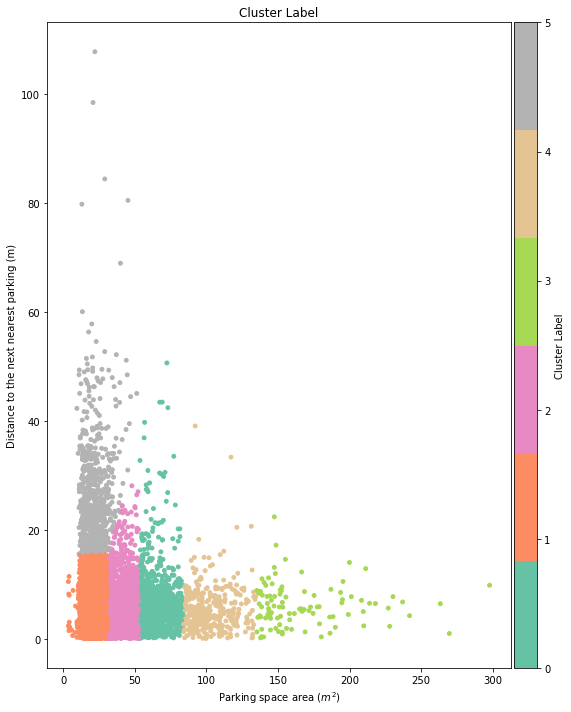

In [23]:
draw_plots_2(6)

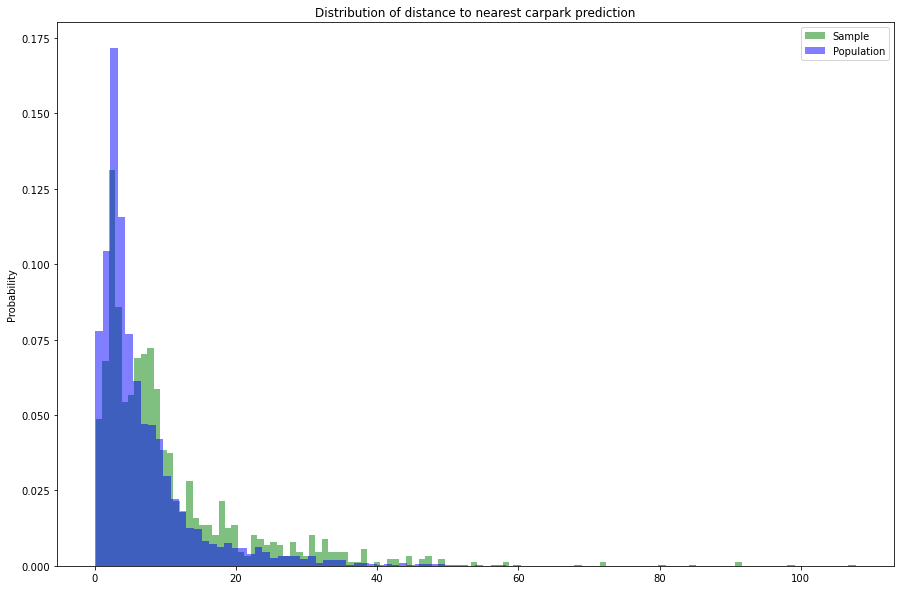

In [24]:
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
# Plot
plt.figure(figsize=(15,10))
plt.hist(df_parking.nearest_geometry_dis, **kwargs, color='g', label='Sample')
plt.hist(df_pop.nearest_geometry_dis, **kwargs, color='b', label='Population')
plt.gca().set(title='Distribution of distance to nearest carpark prediction', ylabel='Probability')
plt.legend();

In [25]:
df_parking.parking_area_m2.max()

214.5639840295266

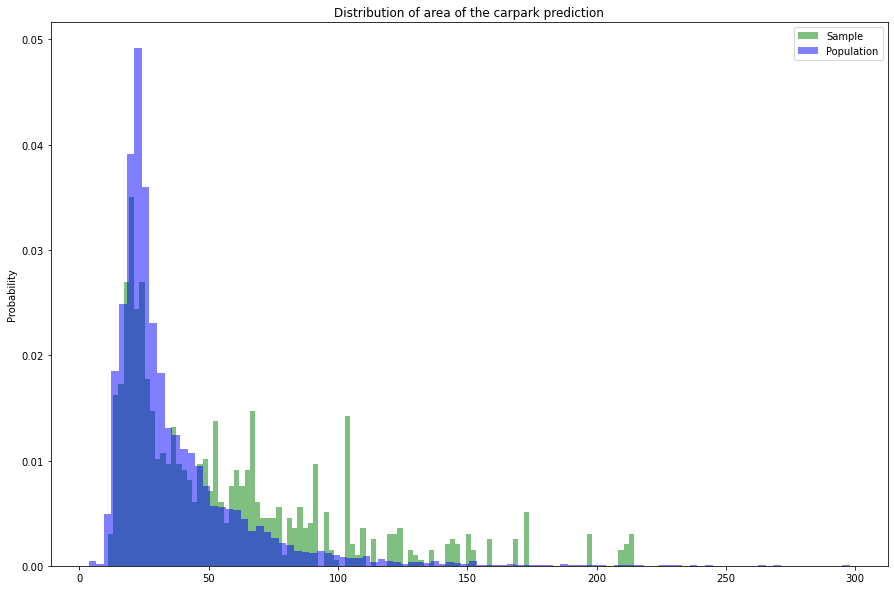

In [26]:
# Plot
plt.figure(figsize=(15,10))
plt.hist(df_parking.parking_area_m2, **kwargs, color='g', label='Sample')
plt.hist(df_pop.parking_area_m2, **kwargs, color='b', label='Population')
plt.gca().set(title='Distribution of area of the carpark prediction', ylabel='Probability')
plt.legend();